More detail to be found in https://github.com/UPOD-datascience/toy_problems/

In [1]:
import sys
sys.path.append('/Users/Danial/Repos/ml')
import pandas as pd
import numpy as np
from src.pipe_store import (
    set_dtypes,
    sklearn_adapter
)
from src.feature_selection import plot_correlations
%load_ext autoreload
%autoreload 2

## Data Loading

In [2]:
with open('/Users/Danial/Repos/ml/data/diabetes.tab.txt') as f:
    lines = f.readlines()
    lines = [line.rstrip().split('\t') for line in lines]
df = pd.DataFrame(lines[1:], columns=lines[0])

In [3]:
data_type = {
    'AGE': 'int16',
    'SEX': 'int16',
    'BMI': 'float16',
    'BP': 'float16',
    'S1': 'int16',    # tc, total serum cholesterol
    'S2': 'float16', #ldl, low-density lipoproteins
    'S3': 'float16', # hdl, high-density lipoproteins
    'S4': 'float16', #tch, total cholesterol / HDL
    'S5': 'float16', # ltg, possibly log of serum triglycerides level
    'S6': 'int16',    # glu, blood sugar level
    'Y': 'int16',
}

In [4]:
X, y = (df
    .pipe(set_dtypes, data_type)
    .pipe(sklearn_adapter, label='Y')
)

Step: set_dtypes | Shape: (442, 11) | Computation Time: 0.006912s


# Feature Selection and multi-colinearity

With a threshold of 0.7 S3 & S4 are colinear

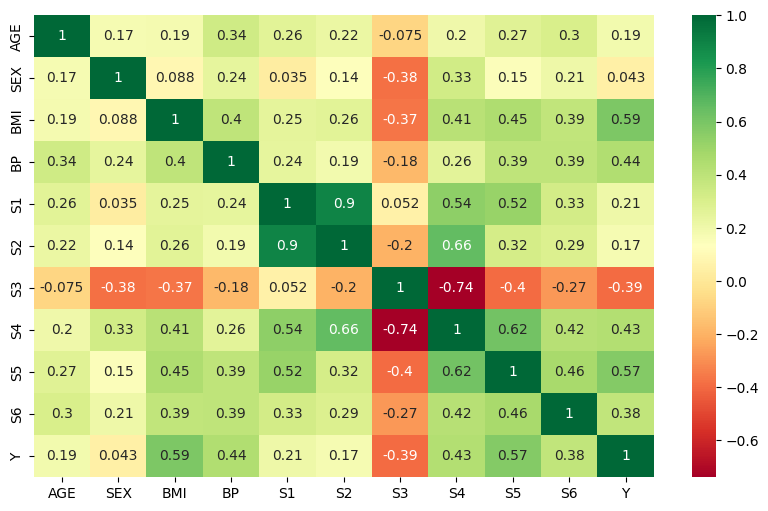

Top Correlations above 0.6
S1  S2    0.896675
S3  S4    0.738487
S2  S4    0.659783
S4  S5    0.617856
dtype: float64


In [5]:
plot_correlations(df)

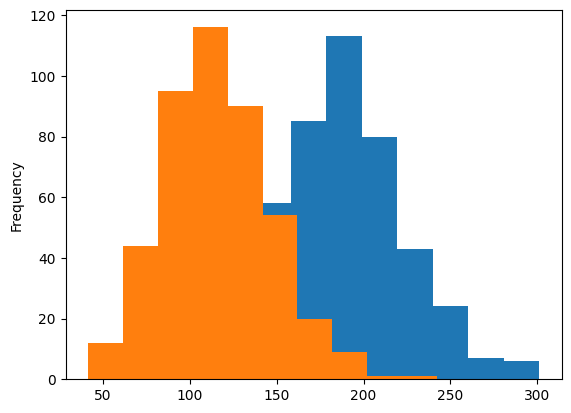

In [6]:
# S1 & S2 are coliniear
df.S1.plot.hist()
df.S2.plot.hist();
df_n = df.drop('S2', axis=1)

## Supervised Feature Selection

### Univariate Feature Selection

In [7]:
from sklearn.feature_selection import  SelectKBest, r_regression, mutual_info_regression, f_regression, f_classif
# cor, pvals = f_regression(X, y)
# pd.DataFrame([cor, pvals]).T
# print(mutual_info_regression(X, y))
X, y = sklearn_adapter(df_n, label="Y")

print(SelectKBest(r_regression, k=6).fit(X, y).get_feature_names_out())
print(SelectKBest(f_regression, k=6).fit(X, y).get_feature_names_out())
print(SelectKBest(mutual_info_regression, k=6).fit(X, y).get_feature_names_out())

['BMI' 'BP' 'S1' 'S4' 'S5' 'S6']
['BMI' 'BP' 'S3' 'S4' 'S5' 'S6']
['BMI' 'S1' 'S3' 'S4' 'S5' 'S6']


In [8]:
# Sex is not correlated with the target variable, [pval is qute large]
f_classif(df['Y'].values.reshape(-1, 1), df['SEX'])

(array([0.81738466], dtype=float32), array([0.36644065], dtype=float32))

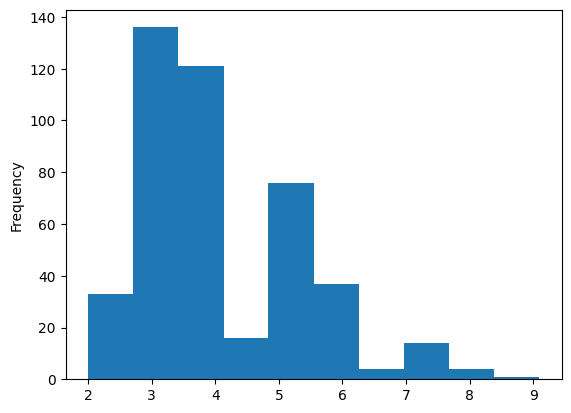

In [9]:
df['S4'].plot.hist();

### Model based Feature selection

## Unsupervised Feature Selection

In [10]:
## Supervised Feature Selection

In [11]:
from sklearn.ensemble import IsolationForest
contamination = 0.4
data = df.drop('Y', axis=1).T
model = IsolationForest(contamination=contamination, n_estimators=200, verbose=1)
model.fit(data)
pred = model.predict(data)
feature = pd.DataFrame(data.index.values, columns=['features'])
feature['relevance'] = pd.Series(pred).map({1 : 0, -1 : 1})
feature
# S1, S2, BMI, SEX, 'BP'

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


,features,relevance
0,AGE,0
1,SEX,1
2,BMI,1
3,BP,0
4,S1,1
5,S2,1
6,S3,0
7,S4,0
8,S5,0
9,S6,0


# Model Building

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

features = ['AGE', 'SEX', 'BMI', 'BP', 'S1', 'S3', 'S5', 'S6'] 
num_cols = set(features) - {'SEX'}
num_cols_ind = [df[features].columns.get_loc(col) for col in num_cols] 
X, y = df[features], df['Y']

column_transformer_scaler = ColumnTransformer([
    ('Scaler', StandardScaler(), ['AGE', 'BMI', 'BP', 'S1', 'S3', 'S5', 'S6']), 
], remainder='passthrough')


In [44]:
from sklearn.model_selection import cross_validate, KFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
random_state = 42

regs = [
    LinearRegression(),
    # RandomForestRegressor(),
    # KNeighborsRegressor(),
    # SVR()
]

results = {}
for reg in regs:

    pipeline = Pipeline([
        ('Scaling', column_transformer_scaler),
        ('Model', reg),
    ], verbose=False)

    kfs = KFold(n_splits=5, shuffle=True, random_state=random_state)
    # For the list of all metrics visit: https://scikit-learn.org/stable/modules/model_evaluation.html
    metrics = ['r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_percentage_error']
    scores = cross_validate(pipeline, X, y, cv=kfs, scoring=metrics)
    # We will not use cross_val_score as it can only accept one metric
    # print(scores)
    reg_name = type(reg).__name__
    results[reg_name] = {key: round(np.mean(val), 3) for key, val in scores.items()}
pd.DataFrame(results)

,LinearRegression
fit_time,0.029
score_time,0.006
test_neg_mean_absolute_error,-44.144
test_neg_mean_absolute_percentage_error,-0.393
test_neg_root_mean_squared_error,-54.690
test_r2,0.482


In [45]:
df

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
0,59,2,32.093750,101.0000,157,93.1875,38.0,4.000000,4.859375,87,151
1,48,1,21.593750,87.0000,183,103.1875,70.0,3.000000,3.892578,69,75
2,72,2,30.500000,93.0000,156,93.6250,41.0,4.000000,4.671875,85,141
3,24,1,25.296875,84.0000,198,131.3750,40.0,5.000000,4.890625,89,206
4,50,1,23.000000,101.0000,192,125.3750,52.0,4.000000,4.289062,80,135
...,...,...,...,...,...,...,...,...,...,...,...
437,60,2,28.203125,112.0000,185,113.8125,42.0,4.000000,4.984375,93,178
438,47,2,24.906250,75.0000,225,166.0000,42.0,5.000000,4.441406,102,104
439,60,2,24.906250,99.6875,162,106.6250,43.0,3.769531,4.128906,95,132
440,36,1,30.000000,95.0000,201,125.1875,42.0,4.789062,5.128906,85,220
